In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import optuna
from sklearn.model_selection import cross_val_score

/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.__version__

'0.48.0'

In [3]:
gdf_01 = gpd.read_file("results/gdf_combined_25DN2_01.gpkg")
gdf_02 = gpd.read_file("results/gdf_combined_25DN2_02.gpkg")
gdf_03 = gpd.read_file("results/gdf_combined_25DN2_03.gpkg")
gdf_04 = gpd.read_file("results/gdf_combined_25DN2_04.gpkg")
gdf_05 = gpd.read_file("results/gdf_combined_25DN2_05.gpkg")
gdf_06 = gpd.read_file("results/gdf_combined_25DN2_06.gpkg")
gdf_07 = gpd.read_file("results/gdf_combined_25DN2_07.gpkg")
gdf_08 = gpd.read_file("results/gdf_combined_25DN2_08.gpkg")
gdf_09 = gpd.read_file("results/gdf_combined_25DN2_09.gpkg")



In [4]:
gdf_all = pd.concat([gdf_01, gdf_02, gdf_03, gdf_04, gdf_05, gdf_06, gdf_07, gdf_08, gdf_09], ignore_index=True)


In [5]:
print(gdf_all['genus'].value_counts()['Fraxinus'])

866


In [6]:
gdf_all

,genus,index_right,treeID,DEVI,RGBVI,GLI,EGRBDI,EXG,EXR,VARI,...,pground,n,area,XTOP,YTOP,ZTOP,crown_depth,canopy_slenderness,point_density,geometry
0,Prunus,3330.0,3360.0,0.967931,0.433949,14.689493,3.890825,108.079033,38.313247,73.761427,...,25.355547,4922,143.8560,115391.49,487218.49,14.91,6.4800,0.641988,34.214770,POINT (115578.32 487479.67)
1,Crataegus,3083.0,3112.0,0.944983,0.305636,6.774831,1.322292,95.170023,19.730611,19.437092,...,8.337104,8840,276.8490,115243.37,487251.89,3.87,5.5400,0.549920,31.930764,POINT (115569.14 487426.89)
2,Carpinus,2654.0,2679.0,0.935599,1.380837,30.207409,0.667014,82.011842,7.669182,0.299009,...,71.495456,3631,82.7678,115940.49,486572.76,25.58,10.2200,1.336604,43.869717,POINT (116009.22 486494.862)
3,Carpinus,2469.0,2492.0,0.915508,0.522760,19.235957,0.904851,92.030835,11.061575,0.312931,...,64.409393,8432,165.4179,115866.95,486649.45,26.24,10.9600,1.043425,50.973927,POINT (116017.52 486507.791)
4,Crataegus,2267.0,2288.0,0.925205,0.361783,7.860736,2.018914,97.902509,26.674564,9.920113,...,53.133836,16976,345.1331,115813.00,486736.77,23.68,13.0300,0.811723,49.186821,POINT (115996.4 486475.75)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22568,Ulmus,295.0,299.0,0.933417,2.167372,49.880231,0.668424,82.100789,8.517940,inf,...,20.596993,13434,237.6210,118177.89,485157.47,16.42,23.8835,1.667860,56.535407,POINT (118396.953 485482.982)
22569,Ulmus,633.0,639.0,1.039934,6.897406,204.512363,2.754970,84.553593,31.588641,inf,...,6.650397,222904,8252.5170,118330.61,485270.80,3.58,15.9570,0.242505,27.010426,POINT (118396.953 485482.982)
22570,Salix,1734.0,1750.0,0.969636,1.380041,40.246820,2.191372,93.434435,25.001993,18.839052,...,17.483966,10135,367.2308,118100.20,485816.81,27.60,12.4300,0.857891,27.598448,POINT (118611.353 485432.175)
22571,Onbekend,277.0,281.0,0.923183,0.753931,39.977048,1.004067,83.867150,6.462211,inf,...,39.699489,60497,987.4826,118241.52,485434.92,3.11,22.6900,0.831842,61.263864,POINT (118271.889 485565.141)


In [7]:
gdf_all["genus"].value_counts() 

gdf_all_filtered = gdf_all[gdf_all["genus"].isin(gdf_all["genus"].value_counts()[gdf_all["genus"].value_counts() > 10].index)]

In [8]:
gdf_all_filtered['genus'].value_counts()

genus
Tilia             4122
Ulmus             3692
Acer              1948
Platanus          1527
Quercus           1134
Prunus            1117
Populus           1062
Alnus              891
Fraxinus           866
Salix              664
Betula             640
Carpinus           579
Sorbus             465
Malus              422
Robinia            417
Crataegus          328
Aesculus           299
Gleditsia          247
Pyrus              238
Pterocarya         227
Liquidambar        222
Onbekend           209
Metasequoia        207
Fagus              166
Corylus            124
Magnolia           102
Ginkgo              98
Styphnolobium       92
Liriodendron        69
Catalpa             59
Taxodium            33
Ilex                32
Juglans             27
Amelanchier         25
Pinus               24
Castanea            20
Cercidiphyllum      20
Cornus              19
Laburnum            17
Parrotia            16
Thuja               11
Name: count, dtype: int64

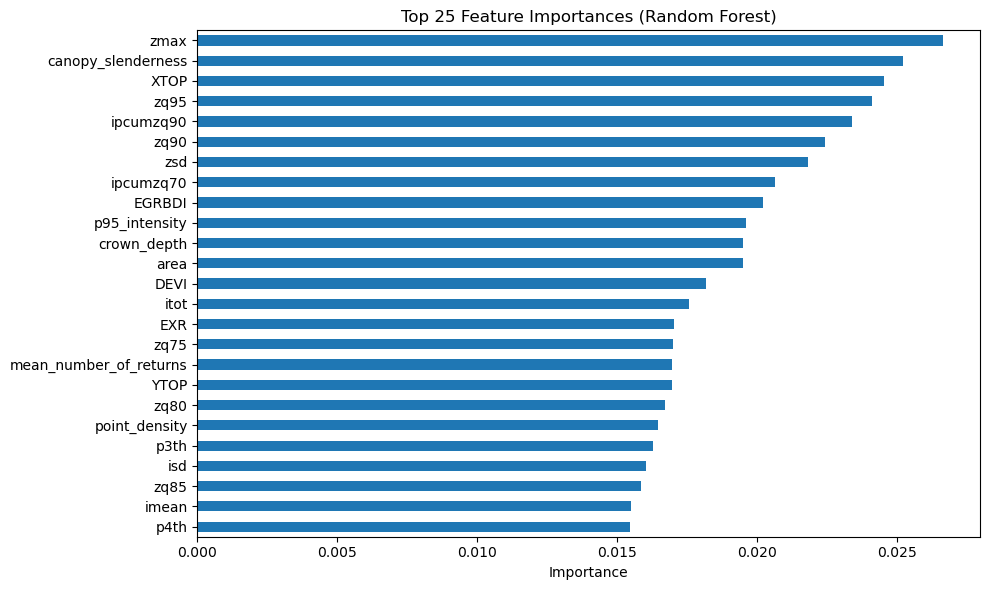

              precision    recall  f1-score   support

        Acer       0.64      0.53      0.58       317
       Alnus       0.69      0.69      0.69       187
    Fraxinus       0.67      0.44      0.53       178
    Platanus       0.88      0.79      0.83       340
     Populus       0.76      0.77      0.77       168
      Prunus       0.78      0.78      0.78       239
     Quercus       0.75      0.51      0.61       174
       Salix       0.70      0.51      0.59       112
       Tilia       0.75      0.90      0.82       841
       Ulmus       0.71      0.78      0.75       718

    accuracy                           0.74      3274
   macro avg       0.73      0.67      0.69      3274
weighted avg       0.74      0.74      0.73      3274



In [ ]:
# random forest
# 1. Select the top 10 most common genera
top10 = gdf_all_filtered['genus'].value_counts().nlargest(10).index
df = gdf_all_filtered[gdf_all_filtered['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# 5. Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42)
rf.fit(X_train, y_train)

# 6. Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

# 7. Plot top 15 features
plt.figure(figsize=(10, 6))
importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 8. Optional: Evaluate model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [14:28:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


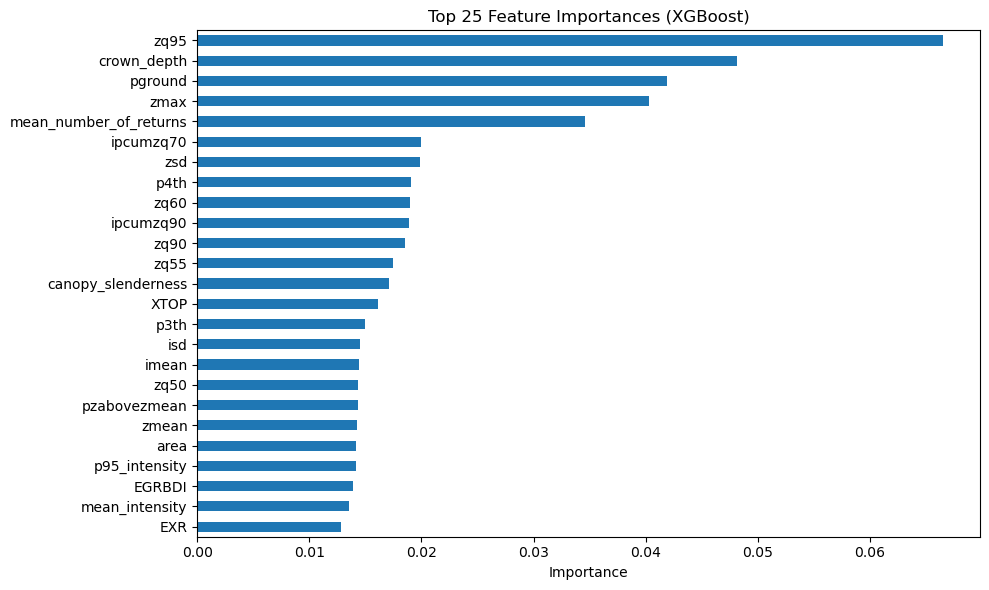

              precision    recall  f1-score   support

        Acer       0.65      0.62      0.63       317
       Alnus       0.73      0.71      0.72       187
    Fraxinus       0.71      0.50      0.59       178
    Platanus       0.85      0.83      0.84       340
     Populus       0.77      0.76      0.77       168
      Prunus       0.80      0.78      0.79       239
     Quercus       0.73      0.59      0.65       174
       Salix       0.72      0.54      0.62       112
       Tilia       0.81      0.89      0.85       841
       Ulmus       0.76      0.82      0.79       718

    accuracy                           0.77      3274
   macro avg       0.75      0.70      0.72      3274
weighted avg       0.77      0.77      0.76      3274



In [9]:
# 1. Select the top 10 most common genera
top10 = gdf_all_filtered['genus'].value_counts().nlargest(10).index
df = gdf_all_filtered[gdf_all_filtered['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)


# Initialize and train XGBoost model

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# Feature importances (XGBoost's built-in)
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 6))
importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Evaluation
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


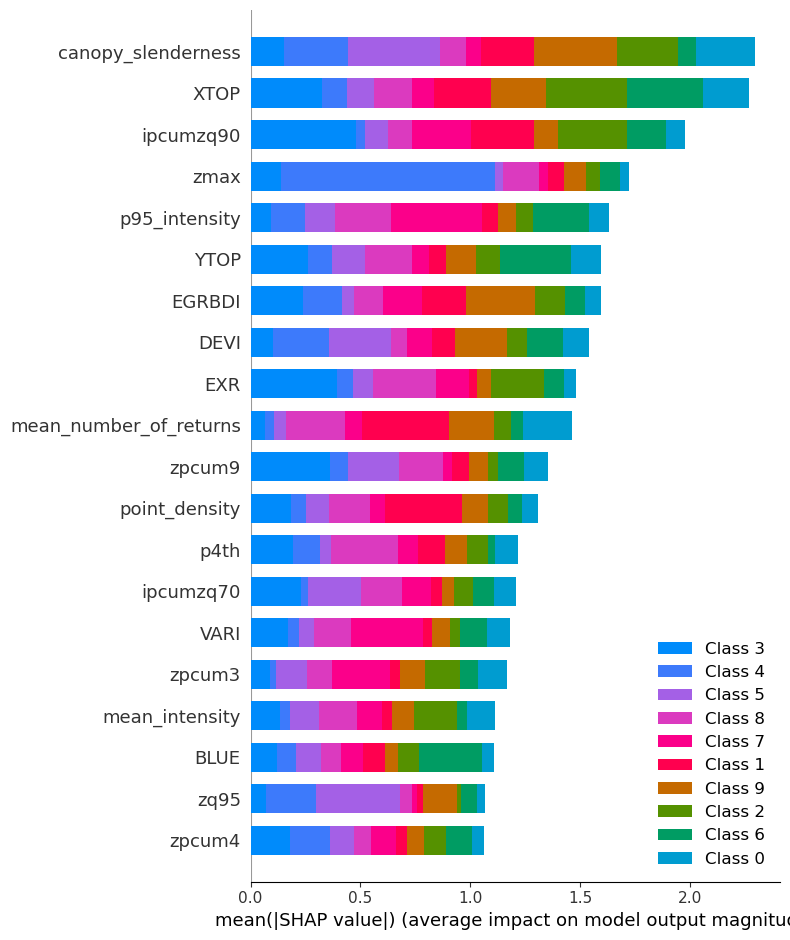

In [10]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

In [15]:

EPS = 1e-9
ZQ_COLS = [f"zq{i}" for i in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]]

def _safe_ratio(a: pd.Series, b: pd.Series) -> pd.Series:
    return a / (b.replace(0, np.nan) + EPS)

def _col_exists(df: pd.DataFrame, col: str) -> bool:
    return col in df.columns

def add_interpretable_ratios(df: pd.DataFrame):
    """Return (augmented_df, new_cols_list). No saving, no side effects."""
    out = df.copy()
    new_cols = []

    def add_ratio(name, num, den, clip01=False):
        if _col_exists(out, num) and _col_exists(out, den):
            out[name] = _safe_ratio(out[num], out[den])
            if clip01:
                out[name] = out[name].clip(0, 1)
            new_cols.append(name)

    # Height profile normalizations
    if _col_exists(out, "zmax"):
        for zq in ZQ_COLS:
            if _col_exists(out, zq):
                name = f"{zq}_over_zmax"
                out[name] = _safe_ratio(out[zq], out["zmax"])
                new_cols.append(name)
        add_ratio("zmean_over_zmax", "zmean", "zmax")
        add_ratio("zsd_over_zmax", "zsd", "zmax")
        if _col_exists(out, "crown_depth"):
            add_ratio("crown_depth_over_zmax", "crown_depth", "zmax")

    # Quantile spreads relative to crown_depth
    if all(_col_exists(out, c) for c in ["crown_depth","zq75","zq25"]):
        out["iqr_z_over_crowndepth"] = _safe_ratio(out["zq75"] - out["zq25"], out["crown_depth"] + EPS)
        new_cols.append("iqr_z_over_crowndepth")
    if all(_col_exists(out, c) for c in ["crown_depth","zq90","zq10"]):
        out["p80_span_over_crowndepth"] = _safe_ratio(out["zq90"] - out["zq10"], out["crown_depth"] + EPS)
        new_cols.append("p80_span_over_crowndepth")
    if all(_col_exists(out, c) for c in ["zq75","zq50","zq25","crown_depth"]):
        out["upper_half_frac"] = _safe_ratio(out["zq75"] - out["zq50"], out["crown_depth"] + EPS)
        out["lower_half_frac"] = _safe_ratio(out["zq50"] - out["zq25"], out["crown_depth"] + EPS)
        new_cols += ["upper_half_frac","lower_half_frac"]

    # Geometry / shape
    if all(_col_exists(out, c) for c in ["area","zmax"]):
        out["area_over_zmax2"] = _safe_ratio(out["area"], (out["zmax"]**2) + EPS)
        new_cols.append("area_over_zmax2")
    if all(_col_exists(out, c) for c in ["point_density","area"]):
        out["density_per_area"] = _safe_ratio(out["point_density"], out["area"] + EPS)
        new_cols.append("density_per_area")

    # Cumulative profile contrasts
    if all(_col_exists(out, c) for c in ["ipcumzq90","ipcumzq50"]):
        add_ratio("top_heaviness_ip", "ipcumzq90", "ipcumzq50")
    if all(_col_exists(out, c) for c in ["pzabovezmean","pzabove2"]):
        add_ratio("above_mean_vs_2m", "pzabovezmean", "pzabove2")

    # Intensity normalizations
    if all(_col_exists(out, c) for c in ["p95_intensity","imean"]):
        add_ratio("p95i_over_imean", "p95_intensity", "imean")
    if all(_col_exists(out, c) for c in ["isd","imean"]):
        add_ratio("isd_over_imean", "isd", "imean")
    if all(_col_exists(out, c) for c in ["imax","p95_intensity"]):
        add_ratio("imax_over_p95i", "imax", "p95_intensity")

    # Selected spectral cross-ratios
    for a in ["EXG","VARI","RGBVI","GLI","DEVI","ndvi_mean"]:
        for b in ["EXG","VARI","RGBVI","GLI","DEVI","ndvi_mean"]:
            if a != b and _col_exists(out, a) and _col_exists(out, b):
                name = f"{a}_over_{b}"
                out[name] = _safe_ratio(out[a], out[b])
                new_cols.append(name)

    # Coordinate standardization (keeps info, removes absolute site bias)
    if all(_col_exists(out, c) for c in ["XTOP","YTOP"]):
        out["XTOP_std"] = (out["XTOP"] - out["XTOP"].mean()) / (out["XTOP"].std() + EPS)
        out["YTOP_std"] = (out["YTOP"] - out["YTOP"].mean()) / (out["YTOP"].std() + EPS)
        new_cols += ["XTOP_std","YTOP_std"]

    # Clean infs produced by divisions
    out = out.replace([np.inf, -np.inf], np.nan)

    return out, new_cols

def add_pairwise_ratios(df: pd.DataFrame):
    """Optional broader ratios across whitelisted groups. Returns (augmented_df, new_cols_list)."""
    out = df.copy(); new_cols = []
    def add_group(cols, prefix):
        cols = [c for c in cols if _col_exists(out, c)]
        for i, a in enumerate(cols):
            for j, b in enumerate(cols):
                if i == j: 
                    continue
                name = f"{prefix}_{a}_over_{b}"
                out[name] = _safe_ratio(out[a], out[b])
                new_cols.append(name)

    add_group([c for c in ZQ_COLS if _col_exists(out, c)], "r_zq")
    add_group([c for c in ["imean","isd","imax","p95_intensity"] if _col_exists(out, c)], "r_i")
    add_group([c for c in ["EXG","VARI","RGBVI","GLI","DEVI","ndvi_mean"] if _col_exists(out, c)], "r_vi")
    add_group([c for c in ["ipcumzq10","ipcumzq30","ipcumzq50","ipcumzq70","ipcumzq90","pzabovezmean","pzabove2"] if _col_exists(out, c)], "r_cum")
    out = out.replace([np.inf, -np.inf], np.nan)
    return out, new_cols


In [36]:
gdf_all_aug, added_cols = add_interpretable_ratios(gdf_all) 

In [39]:
added_cols

['zq5_over_zmax',
 'zq10_over_zmax',
 'zq15_over_zmax',
 'zq20_over_zmax',
 'zq25_over_zmax',
 'zq30_over_zmax',
 'zq35_over_zmax',
 'zq40_over_zmax',
 'zq45_over_zmax',
 'zq50_over_zmax',
 'zq55_over_zmax',
 'zq60_over_zmax',
 'zq65_over_zmax',
 'zq70_over_zmax',
 'zq75_over_zmax',
 'zq80_over_zmax',
 'zq85_over_zmax',
 'zq90_over_zmax',
 'zq95_over_zmax',
 'zmean_over_zmax',
 'zsd_over_zmax',
 'crown_depth_over_zmax',
 'iqr_z_over_crowndepth',
 'p80_span_over_crowndepth',
 'upper_half_frac',
 'lower_half_frac',
 'area_over_zmax2',
 'density_per_area',
 'top_heaviness_ip',
 'above_mean_vs_2m',
 'p95i_over_imean',
 'isd_over_imean',
 'imax_over_p95i',
 'EXG_over_VARI',
 'EXG_over_RGBVI',
 'EXG_over_GLI',
 'EXG_over_DEVI',
 'VARI_over_EXG',
 'VARI_over_RGBVI',
 'VARI_over_GLI',
 'VARI_over_DEVI',
 'RGBVI_over_EXG',
 'RGBVI_over_VARI',
 'RGBVI_over_GLI',
 'RGBVI_over_DEVI',
 'GLI_over_EXG',
 'GLI_over_VARI',
 'GLI_over_RGBVI',
 'GLI_over_DEVI',
 'DEVI_over_EXG',
 'DEVI_over_VARI',
 'DEVI

/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [15:15:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


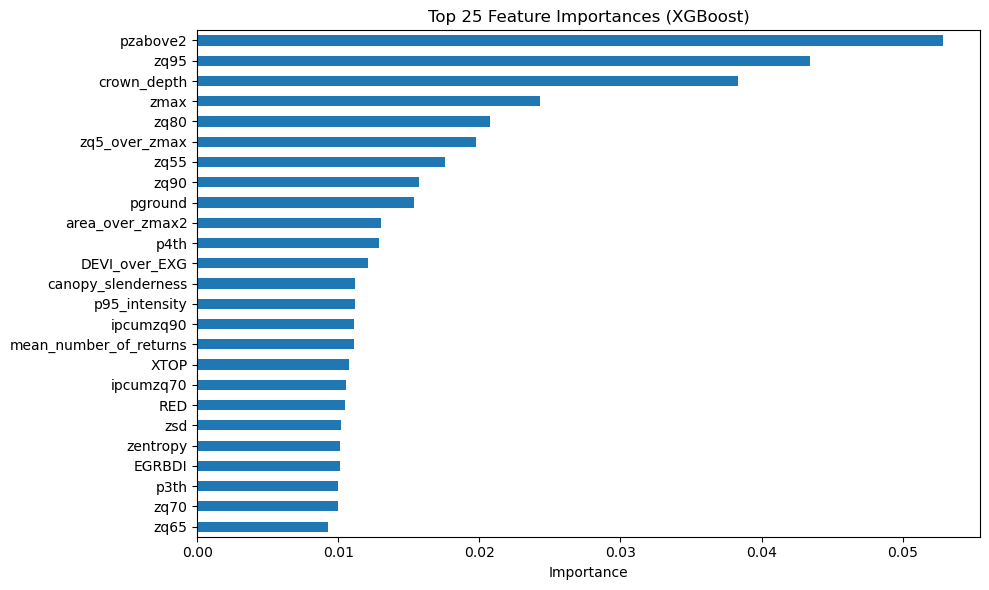

              precision    recall  f1-score   support

        Acer       0.63      0.63      0.63       317
       Alnus       0.75      0.71      0.73       187
    Fraxinus       0.65      0.46      0.54       178
    Platanus       0.85      0.83      0.84       340
     Populus       0.82      0.76      0.79       168
      Prunus       0.79      0.82      0.80       238
     Quercus       0.74      0.54      0.63       175
       Salix       0.70      0.53      0.60       112
       Tilia       0.81      0.90      0.85       840
       Ulmus       0.76      0.83      0.80       718

    accuracy                           0.77      3273
   macro avg       0.75      0.70      0.72      3273
weighted avg       0.77      0.77      0.77      3273



In [21]:
# 1. Select the top 10 most common genera
top10 = gdf_all_aug['genus'].value_counts().nlargest(10).index
df = gdf_all_aug[gdf_all_aug['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)


# Initialize and train XGBoost model

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# Feature importances (XGBoost's built-in)
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 6))
importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Evaluation
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


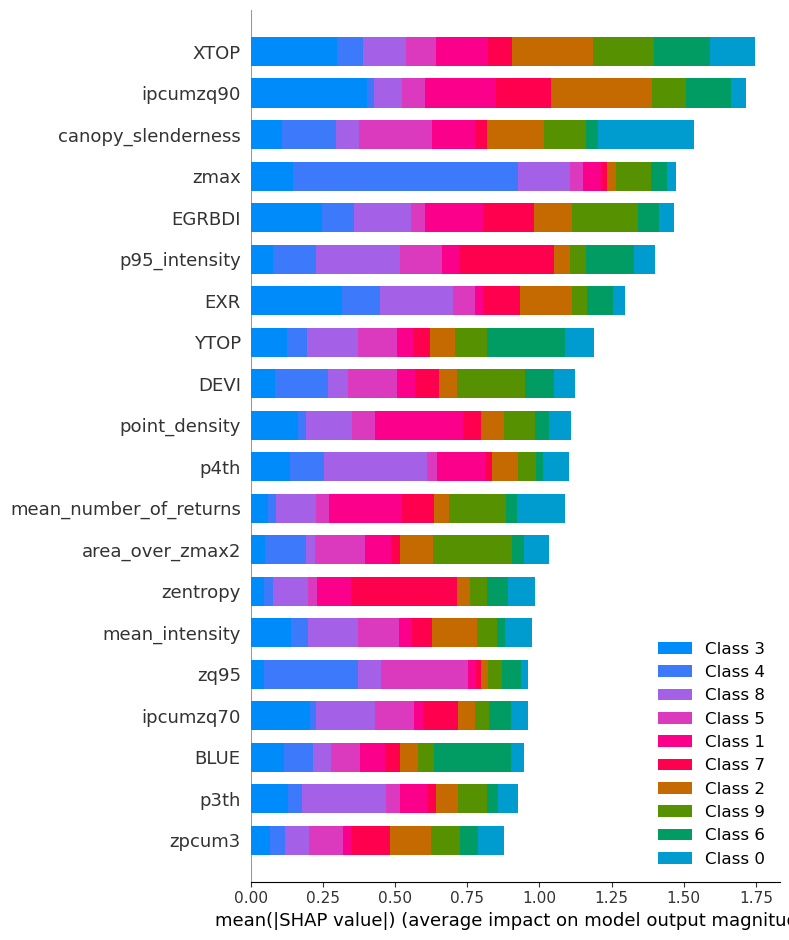

In [22]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

In [18]:

# ---------------- Core utilities ----------------

def _numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    num = df.select_dtypes(include=[np.number]).copy()
    # Drop all-NaN columns (corr/vif can't handle them)
    num = num.loc[:, ~num.isna().all(axis=0)]
    # Optionally fill NaNs with column medians for corr/VIF stability
    return num.fillna(num.median(numeric_only=True))

def collinearity_report(
    df: pd.DataFrame,
    method: str = "spearman",
    threshold: float = 0.95
) -> dict:
    """
    Returns:
      {
        'pairs': DataFrame of highly correlated pairs with |corr|>=threshold,
        'clusters': List[List[str]] of collinear groups,
        'corr': full absolute correlation DataFrame (numeric cols only)
      }
    """
    X = _numeric_df(df)
    corr = X.corr(method=method).abs()

    # Collect pairs from upper triangle
    pairs = []
    cols = corr.columns.tolist()
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            c = corr.iat[i, j]
            if np.isfinite(c) and c >= threshold:
                pairs.append((cols[i], cols[j], float(c)))

    pairs_df = pd.DataFrame(pairs, columns=["feature_a", "feature_b", "abs_corr"]).sort_values("abs_corr", ascending=False)

    # Build clusters via union-find
    parent = {c: c for c in cols}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    for a, b, _ in pairs:
        union(a, b)

    clusters_map = {}
    for c in cols:
        r = find(c)
        clusters_map.setdefault(r, []).append(c)

    # Keep only clusters with at least one pair above threshold
    keep_roots = set()
    for a, b, _ in pairs:
        keep_roots.add(find(a))
        keep_roots.add(find(b))
    clusters = [sorted(clusters_map[r]) for r in keep_roots]

    return {"pairs": pairs_df, "clusters": clusters, "corr": corr}


def prune_collinear(
    df: pd.DataFrame,
    method: str = "spearman",
    threshold: float = 0.95,
    feature_importances: dict | None = None,
    prefer_lower_avg_corr: bool = True,
    protected: set[str] | None = None
) -> tuple[pd.DataFrame, dict]:
    """
    Drops one feature from each highly-correlated pair until no |corr|>=threshold remain.
    - If `feature_importances` is provided (e.g. SHAP mean |value|: {'zmax': 0.12, ...}),
      we keep the more important feature.
    - Otherwise (or tie), we keep the feature with lower mean absolute correlation to others.
    - `protected`: features you never want to drop.

    Returns: (df_reduced, report)
      report = {
        'dropped': list_of_dropped_features,
        'kept': list_of_kept_features,
        'decisions': list of tuples (drop, keep, reason, corr_value)
      }
    """
    protected = protected or set()

    X = _numeric_df(df)
    corr = X.corr(method=method).abs()
    corr.values[[np.arange(corr.shape[0])]*2, [np.arange(corr.shape[1])]*2] = 0.0

    dropped = []
    decisions = []

    def current_pairs():
        # Return list of pairs above threshold, highest first
        pairs = []
        cols = corr.columns
        for i in range(len(cols)):
            for j in range(i+1, len(cols)):
                c = corr.iat[i, j]
                if np.isfinite(c) and c >= threshold:
                    pairs.append((cols[i], cols[j], float(c)))
        pairs.sort(key=lambda t: t[2], reverse=True)
        return pairs

    def avg_abs_corr(col):
        # Mean abs corr of col with others (excluding self)
        vals = corr[col].drop(labels=[col], errors="ignore")
        return float(np.nanmean(vals.values)) if len(vals) else 0.0

    pairs = current_pairs()
    while pairs:
        a, b, cval = pairs[0]

        # Skip if one is already dropped
        if a in dropped or b in dropped:
            pairs = pairs[1:]
            continue

        # Respect protected features
        if a in protected and b in protected:
            # Can't drop either: lower threshold or accept collinearity
            decisions.append((None, None, f"Both protected; left as-is (corr={cval:.3f})", cval))
            pairs = pairs[1:]
            continue
        elif a in protected:
            to_keep, to_drop = a, b
        elif b in protected:
            to_keep, to_drop = b, a
        else:
            # Use importance if provided
            if feature_importances:
                ia = feature_importances.get(a, None)
                ib = feature_importances.get(b, None)
            else:
                ia = ib = None

            if ia is not None or ib is not None:
                # Keep higher importance (None treated as -inf)
                ia = -np.inf if ia is None else ia
                ib = -np.inf if ib is None else ib
                if ia >= ib:
                    to_keep, to_drop = a, b
                    reason = f"kept '{a}' over '{b}' (importance {ia:.3g} ≥ {ib:.3g})"
                else:
                    to_keep, to_drop = b, a
                    reason = f"kept '{b}' over '{a}' (importance {ib:.3g} > {ia:.3g})"
            else:
                # Fall back: keep the one with lower mean abs corr to others
                aa = avg_abs_corr(a)
                bb = avg_abs_corr(b)
                if prefer_lower_avg_corr:
                    if aa <= bb:
                        to_keep, to_drop = a, b
                        reason = f"kept '{a}' (lower avg|corr| {aa:.3f} ≤ {bb:.3f})"
                    else:
                        to_keep, to_drop = b, a
                        reason = f"kept '{b}' (lower avg|corr| {bb:.3f} < {aa:.3f})"
                else:
                    # Keep higher avg corr (rarely used)
                    if aa >= bb:
                        to_keep, to_drop = a, b
                        reason = f"kept '{a}' (higher avg|corr| {aa:.3f} ≥ {bb:.3f})"
                    else:
                        to_keep, to_drop = b, a
                        reason = f"kept '{b}' (higher avg|corr| {bb:.3f} > {aa:.3f})"

        dropped.append(to_drop)
        decisions.append((to_drop, to_keep, f"{reason}; pair |corr|={cval:.3f}", cval))

        # Zero out correlations for the dropped feature (simulate removing it)
        if to_drop in corr.columns:
            corr.loc[:, to_drop] = 0.0
            corr.loc[to_drop, :] = 0.0

        pairs = current_pairs()

    kept = [c for c in _numeric_df(df).columns if c not in dropped]
    reduced = df.drop(columns=[c for c in dropped if c in df.columns], errors="ignore")

    report = {"dropped": dropped, "kept": kept, "decisions": decisions}
    return reduced, report


# ---------------- Optional: VIF (Variance Inflation Factor) ----------------

def compute_vif(df: pd.DataFrame, max_features: int = 100) -> pd.DataFrame:
    """
    Compute VIF for up to `max_features` numeric columns.
    Requires statsmodels: conda install -c conda-forge statsmodels
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = _numeric_df(df)
    # VIF is O(k^2); cap feature count if needed
    if X.shape[1] > max_features:
        # Keep the first max_features (or choose by variance)
        X = X.iloc[:, :max_features].copy()

    # Add intercept for VIF stability
    X_ = X.copy()
    X_["__intercept__"] = 1.0

    vif_vals = []
    for i, col in enumerate(X.columns):
        try:
            vif = variance_inflation_factor(X_.values, i)
        except Exception as e:
            vif = np.nan
        vif_vals.append((col, vif))
    return pd.DataFrame(vif_vals, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)


In [20]:
rep = collinearity_report(gdf_all_aug, method="spearman", threshold=0.95)
pairs = rep["pairs"]          # table of (feature_a, feature_b, abs_corr)
clusters = rep["clusters"]    
print(pairs.head(20))
print("Num clusters:", len(clusters))
for grp in clusters[:5]:
    print("Cluster:", grp)

              feature_a        feature_b  abs_corr
15       mean_intensity            imean  1.000000
101       EXG_over_DEVI    DEVI_over_EXG  1.000000
85                 YTOP         YTOP_std  1.000000
84                 XTOP         XTOP_std  1.000000
86   canopy_slenderness  area_over_zmax2  1.000000
0           index_right           treeID  0.999995
37                  zq5    zq5_over_zmax  0.999988
16        std_intensity              isd  0.999970
38                 zq10   zq10_over_zmax  0.999928
7                   GLI    GLI_over_DEVI  0.999868
111       GLI_over_DEVI    DEVI_over_GLI  0.999867
98         EXG_over_GLI     GLI_over_EXG  0.999867
39                 zq15   zq15_over_zmax  0.999810
8                   GLI    DEVI_over_GLI  0.999735
3                 RGBVI  RGBVI_over_DEVI  0.999713
40                 zq20   zq20_over_zmax  0.999648
13                 VARI   VARI_over_DEVI  0.999426
72            ipcumzq10        ipcumzq30  0.999401
67             ipground        

In [47]:
# Define the columns you never want dropped
protected_cols = {"geometry", "index_right", "treeID", "genus"}

# Run pruning on augmented dataframe
gdf_all_reduced, report = prune_collinear(
    gdf_all_aug,
    method="spearman",    # or "pearson"
    threshold=0.75,       # adjust if you want stricter/looser pruning
    protected=protected_cols
)

print("Dropped features:", report["dropped"][:20])   # first 20 dropped
print("Kept features:", len(report["kept"]))
print("Total dropped:", len(report["dropped"]))

Dropped features: ['imean', 'XTOP_std', 'YTOP_std', 'EXG_over_DEVI', 'area_over_zmax2', 'zq5', 'std_intensity', 'zq10', 'GLI', 'DEVI_over_GLI', 'EXG_over_GLI', 'zq15', 'RGBVI', 'zq20', 'VARI', 'ipcumzq10', 'zq25', 'ipground', 'RGBVI_over_EXG', 'RGBVI_over_DEVI']
Kept features: 39
Total dropped: 94


/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:16:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


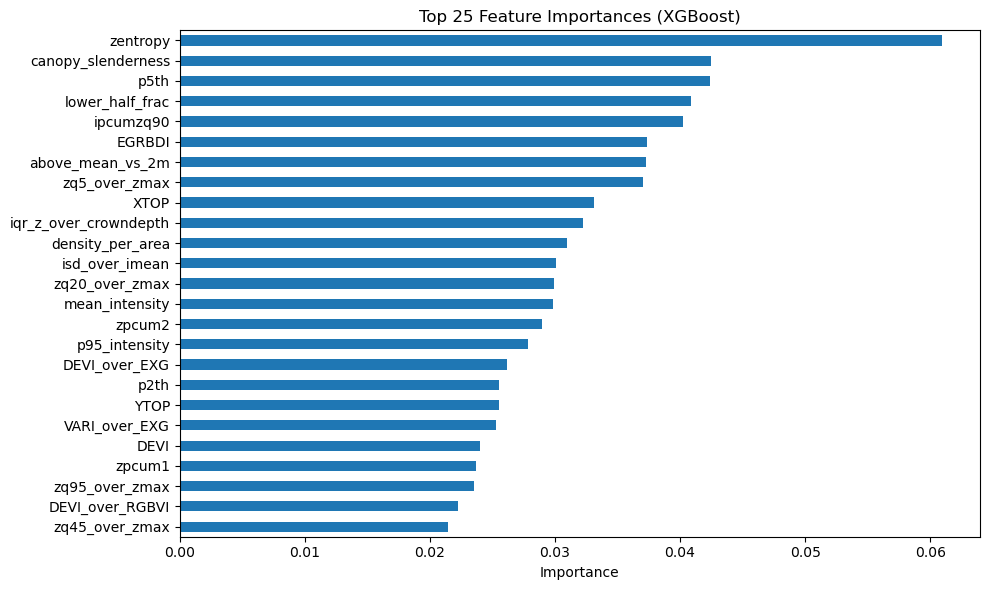

              precision    recall  f1-score   support

        Acer       0.63      0.62      0.62       317
       Alnus       0.72      0.69      0.70       187
    Fraxinus       0.64      0.46      0.53       178
    Platanus       0.89      0.81      0.85       340
     Populus       0.74      0.76      0.75       168
      Prunus       0.79      0.76      0.77       238
     Quercus       0.67      0.55      0.61       175
       Salix       0.65      0.50      0.57       112
       Tilia       0.79      0.87      0.83       840
       Ulmus       0.75      0.82      0.78       720

    accuracy                           0.75      3275
   macro avg       0.73      0.68      0.70      3275
weighted avg       0.75      0.75      0.75      3275



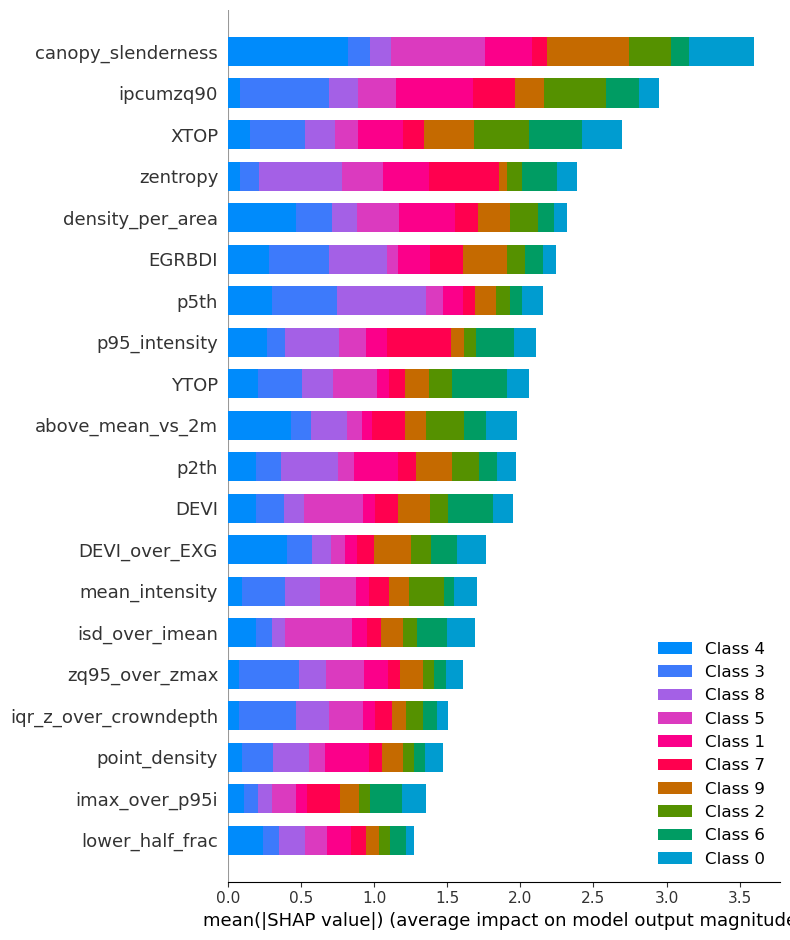

In [48]:
# 1. Select the top 10 most common genera
top10 = gdf_all_reduced['genus'].value_counts().nlargest(10).index
df = gdf_all_reduced[gdf_all_reduced['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)


# Initialize and train XGBoost model

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# Feature importances (XGBoost's built-in)
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 6))
importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Evaluation
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:50:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


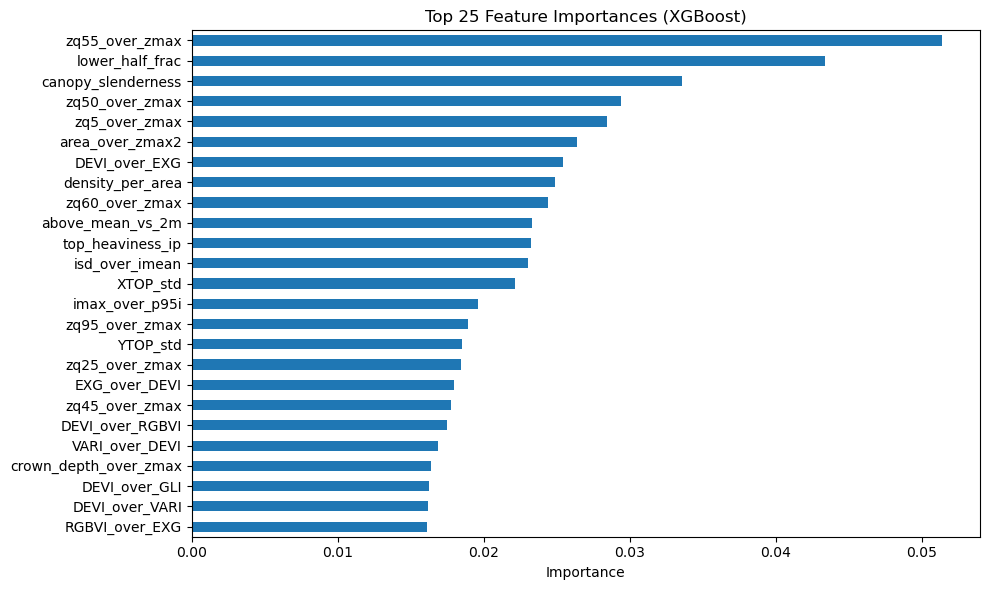

              precision    recall  f1-score   support

        Acer       0.62      0.55      0.59       334
       Alnus       0.67      0.64      0.65       192
    Fraxinus       0.62      0.51      0.56       190
    Platanus       0.82      0.78      0.80       363
     Populus       0.78      0.76      0.77       179
      Prunus       0.76      0.73      0.74       265
     Quercus       0.72      0.54      0.62       182
       Salix       0.64      0.49      0.55       115
       Tilia       0.77      0.85      0.81       883
       Ulmus       0.71      0.80      0.75       762

    accuracy                           0.73      3465
   macro avg       0.71      0.66      0.68      3465
weighted avg       0.73      0.73      0.72      3465



In [40]:
# aug cols with only the added cols + canopy_slenderness
# 1. Select the top 10 most common genera
top10 = gdf_all_aug['genus'].value_counts().nlargest(10).index
df = gdf_all_aug[gdf_all_aug['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in added_cols 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)


# Initialize and train XGBoost model

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.6,
    gamma=0,
    reg_alpha=1,
    reg_lambda=2,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb.fit(X_train, y_train)

# Feature importances (XGBoost's built-in)
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top 25 features
plt.figure(figsize=(10, 6))
importances.head(25).plot(kind='barh')
plt.title('Top 25 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Evaluation
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


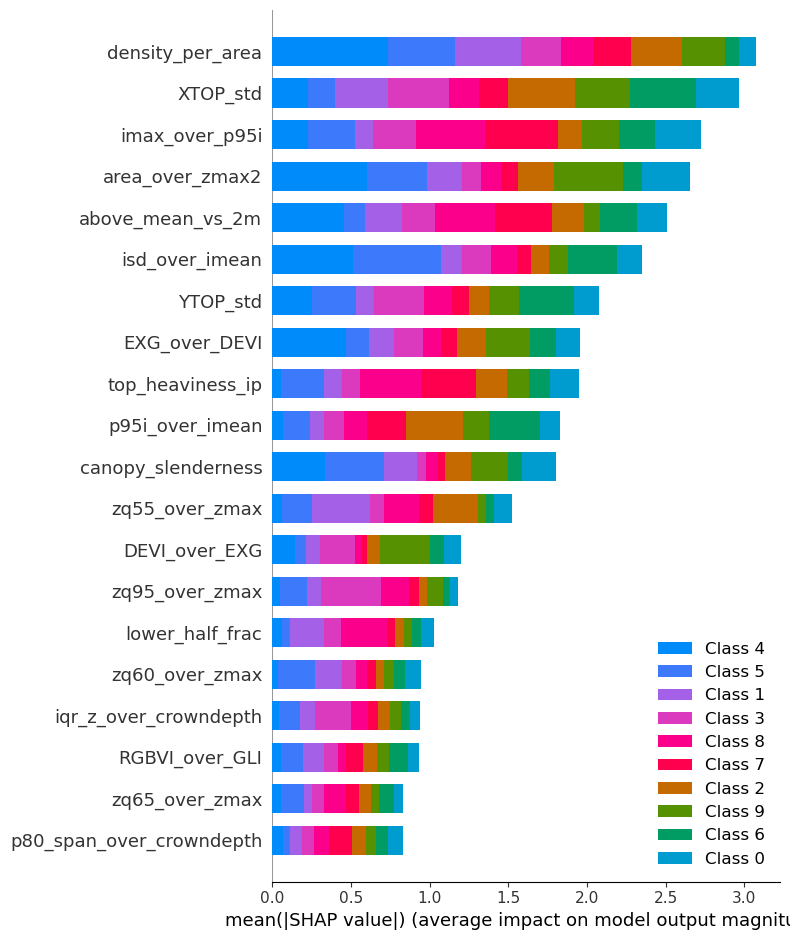

In [41]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

In [ ]:
# opti for accuracy
# 1. Select the top 10 most common genera
top10 = gdf_all_filtered['genus'].value_counts().nlargest(10).index
df = gdf_all_filtered[gdf_all_filtered['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

# 2. Define the classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# 3. Define the hyperparameter space
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 1.5, 2]
}

# 4. Perform randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    scoring="accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X, y_encoded)

# 5. View best parameters
print("Best parameters found:")
print(random_search.best_params_)

# 6. Evaluate best model
best_model = random_search.best_estimator_

# # Optionally evaluate
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)
# best_model.fit(X_train, y_train)
# y_pred = best_model.predict(X_test)

# print(classification_report(y_test, y_pred, target_names=le.classes_))


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:39:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:39:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:39:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3

Best parameters found:
{'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6}


In [28]:
# f1_weighted larger space
top10 = gdf_all_filtered['genus'].value_counts().nlargest(10).index
df = gdf_all_filtered[gdf_all_filtered['genus'].isin(top10)].copy()

exclude_cols = ['geometry', 'index_right', 'treeID', 'genus']
# 2. Define features and target
feature_cols = [col for col in df.columns 
                if col not in exclude_cols 
                and df[col].dtype in [np.float64, np.int64] 
                and not col.endswith('_x') 
                and not col.endswith('_y')]

X = df[feature_cols]
y = df['genus']

# Replace inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaNs in features
X = X.dropna()
y = y.loc[X.index]  

# 3. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Make sure y matches X

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 3.0),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    model = XGBClassifier(**params)

    # Use cross-validation on your TRAINING set
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_trial.params)

[I 2025-07-02 17:26:56,093] A new study created in memory with name: no-name-1f0c353b-da11-4159-bcab-5e5bfe785565
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:26:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:27:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/rommetevelde/miniforge3/envs/aitrees/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:27:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } 

Best parameters: {'n_estimators': 232, 'max_depth': 12, 'learning_rate': 0.18734190032112236, 'subsample': 0.7618931425651347, 'colsample_bytree': 0.8871391824464006, 'reg_alpha': 0.12616087417005464, 'reg_lambda': 2.549403280838206, 'gamma': 0.002200246135661263}


In [31]:
best_params = study.best_trial.params
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8871391824464006, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.002200246135661263, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.18734190032112236, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=232, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        Acer       0.63      0.63      0.63       317
       Alnus       0.71      0.68      0.70       187
    Fraxinus       0.69      0.49      0.57       178
    Platanus       0.86      0.83      0.84       340
     Populus       0.79      0.77      0.78       168
      Prunus       0.83      0.81      0.82       239
     Quercus       0.77      0.58      0.66       174
       Salix       0.70      0.51      0.59       112
       Tilia       0.81      0.90      0.85       841
       Ulmus       0.77      0.83      0.80       718

    accuracy                           0.77      3274
   macro avg       0.75      0.70      0.72      3274
weighted avg       0.77      0.77      0.77      3274



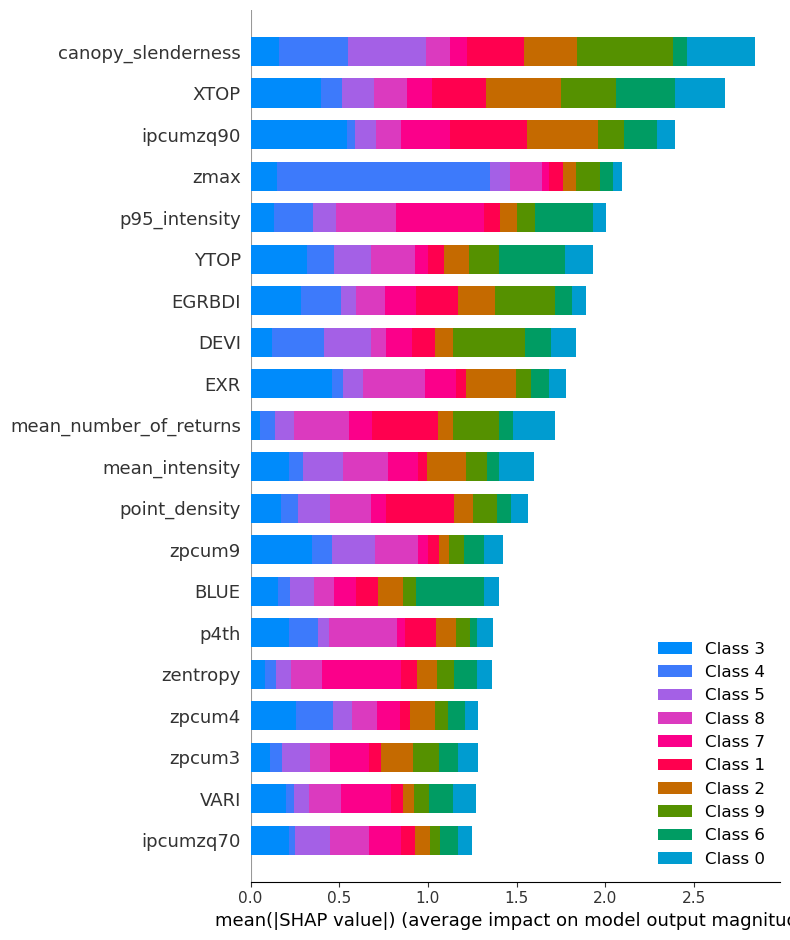

In [30]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

In [ ]:
# shap values
# geogrpahic distribution berekenen per stadsdeel

In [24]:
top10 = gdf_all_filtered['genus'].value_counts().nlargest(10).index
df = gdf_all_filtered[gdf_all_filtered['genus'].isin(top10)].copy()
print(len(df))

17023
